<img src ="Images/GatorGlaciologyLogo-01.jpg" width="100" align = "right">

# Simple kriging and ordinary kriging
#### Gator Glaciology Lab, University of Florida

Here we implement simple kriging and ordinary kriging for a case study using variogram parameters from 2_Variogram_model.ipynb. 

Kriging is a deterministic interpolation algorithm, where the goal is to minimize estimation variance, or optimize accuracy. Each interpolated value is the weighted sum of neighboring measurements. These weights are determined using the variogram so that the spatial structure of the data is accounted for. The variogram is also used to compute the uncertainty, or variance, at each location. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg
from skgstat import models
import GStatSim as gs
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

## Load and plot data

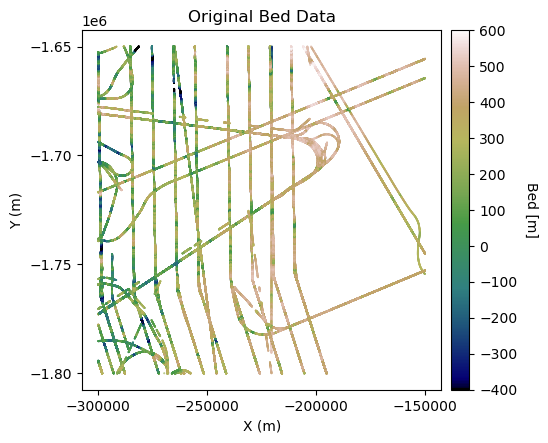

In [2]:
df_bed = pd.read_csv('Data/greenland_test_data.csv')

# remove erroneously high values due to bad bed picks
df_bed = df_bed[df_bed["Bed"] <= 700]  

# plot original data
plt.figure(figsize=(5,5))
im = plt.scatter(df_bed['X'], df_bed['Y'], c=df_bed['Bed'], vmin=-400, vmax=600, 
                 marker='.', s=0.5, cmap='gist_earth')
plt.title('Original Bed Data')
plt.xlabel('X (m)'); plt.ylabel('Y (m)')
plt.locator_params(nbins=5)

# make colorbar
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label('Bed [m]', rotation=270, labelpad=15)

ax.axis('scaled')
plt.show()

## Grid and transform data. Get variogram parameters

See variogram tutorials for details

In [3]:
# grid data to 100 m resolution and remove coordinates with NaNs
res = 1000
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)
df_grid = df_grid[df_grid["Z"].isnull() == False]
df_grid = df_grid.rename(columns = {"Z": "Bed"})

# normal score transformation
data = df_grid['Bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 50000             # maximum range distance
n_lags = 70                # num of bins

V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, 
                   maxlag=maxlag, normalize=False)

# use exponential variogram model
V1.model = 'exponential'
V1.parameters

[31852.813386947026, 0.7027482243110261, 0]

These outputs are the variogram range, sill, and nugget, respectively. We will need this information for kriging.

## Initialize grid

First we need to define a grid to interpolate. This stores an array of coordinates for the simulation.

In [4]:
# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

## Simple kriging

Simple kriging assumes that the mean is stationary and known. The data is treated as a residual from the mean, which is computed as the average of conditioning points. Sometimes this is a good assumption, but in some cases it is not. We will apply it here to see what happens.

In [5]:
# set variogram parameters
azimuth = 0
nugget = V1.parameters[2]

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0]
minor_range = V1.parameters[0]
sill = V1.parameters[1]

# save variogram parameters as a list
vario = [azimuth, nugget, major_range, minor_range, sill]

# number of neighboring data points used to estimate a given point 
k = 100

# 50 km search radius
rad = 50000

# est_SK is the estimate and var_SK is the variance
est_SK, var_SK = gs.Interpolation.skrige(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad)

100%|████████████████████████████████████| 22500/22500 [02:23<00:00, 156.38it/s]


Although the SciKit-GStat package fits a sill parameter, we prefer to use a sill of 1 because it makes the covariance zero for measurements with lag distances greater than the range, which tends to make simulation algorithms run better. However, you can still substitute in a different sill value if you wish.

Here, k is the number of conditioning nodes used to estimate a grid cell. This means that each estimate will be informed the by k nearby measurements within a specified search radius. The search radius should be at least as large as the largest measurement gap. If you're getting errors, it is usually because the radius is too small. Generally speaking, increasing the search radius and number of conditioning nodes improves the simulation quality.

The simulation is applied to the transformed data, so a reverse normal score transformation must be applied to recover the original distribution.

In [6]:
# reverse normal score transformation

var_SK[var_SK < 0] = 0      # make sure variances are non-negative
std_SK = np.sqrt(var_SK)    # convert to standard deviation before back transforming

# reshape
est = est_SK.reshape(-1,1)
std = std_SK.reshape(-1,1)

# back transformation
spred_trans = nst_trans.inverse_transform(est)
sstd_trans = nst_trans.inverse_transform(std)
sstd_trans = sstd_trans - np.min(sstd_trans)

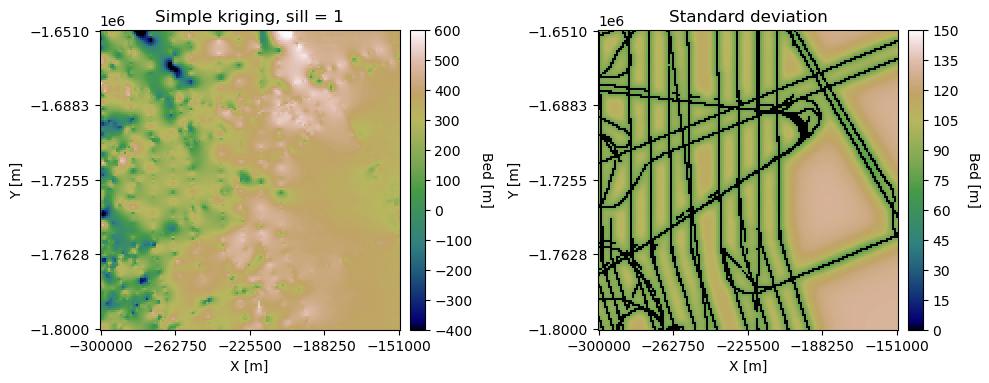

CPU times: user 400 ms, sys: 12.4 ms, total: 412 ms
Wall time: 152 ms


In [7]:
# create matrices of coordinates and transformed kriging estimates
x_mat = Pred_grid_xy[:,0].reshape(grid_matrix.shape)
y_mat = Pred_grid_xy[:,1].reshape(grid_matrix.shape)
spred_trans_mat = spred_trans.reshape(grid_matrix.shape)
sstd_trans_mat = sstd_trans.reshape(grid_matrix.shape)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5))

im = ax1.pcolormesh(x_mat, y_mat, spred_trans_mat, vmin=-400, vmax=600, cmap='gist_earth')
ax1.set_xticks(np.linspace(xmin, xmax, 5))
ax1.set_yticks(np.linspace(ymin, ymax, 5))
ax1.set_title('Simple kriging, sill = 1')
ax1.set_xlabel('X [m]'); ax1.set_ylabel('Y [m]')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label('Bed [m]', rotation=270, labelpad=15)
ax1.axis('scaled')

im = ax2.pcolormesh(x_mat, y_mat, sstd_trans_mat, vmin=0, vmax=150, cmap='gist_earth')
ax2.set_xticks(np.linspace(xmin, xmax, 5))
ax2.set_yticks(np.linspace(ymin, ymax, 5))
ax2.set_title('Standard deviation')
ax2.set_xlabel('X [m]'); ax2.set_ylabel('Y [m]')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(0, 150, 11), cax=cax)
cbar.set_label('Bed [m]', rotation=270, labelpad=15)
ax2.axis('scaled')

plt.tight_layout()
plt.show()

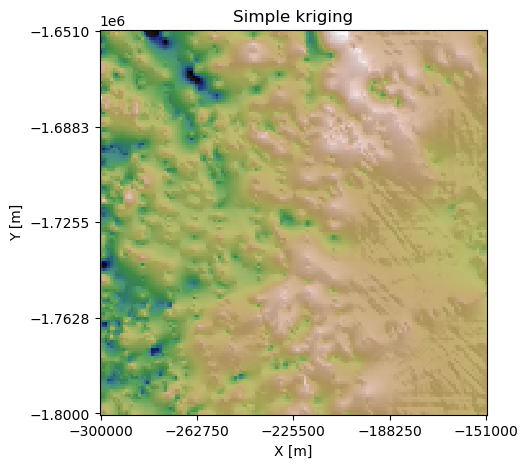

In [8]:
# make hillshade plot for visualizing
hillshade = es.hillshade(spred_trans_mat, azimuth = 210, altitude = 10)

plt.figure(figsize=(5,5))
plt.pcolormesh(x_mat, y_mat, spred_trans_mat, vmin=-400, vmax=600, cmap='gist_earth')
plt.pcolormesh(x_mat, y_mat, hillshade, cmap='Greys', alpha=0.1)
plt.title('Simple kriging')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.xticks(np.linspace(xmin, xmax, 5))
plt.yticks(np.linspace(ymin, ymax, 5))
plt.show()

The downside of simple kriging is that it assumes that all the data points are a residual from a constant mean across the area. This could give us a biased estimate, especially if there are differences in data density at different elevations. Let's try ordinary kriging, where the mean is unknown.

## Ordinary kriging

Ordinary kriging (OK) uses a locally varying mean. This makes OK more robust to trends.

In [9]:
k = 100
est_OK, var_OK = gs.Interpolation.okrige(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad) # estimation and variance

# reverse normal score transformation
var_OK[var_OK < 0] = 0; # make sure variances are non-negative
std_OK = np.sqrt(var_OK) # convert to standard deviation (this should be done before back transforming!!!)

# reshape
est = est_OK.reshape(-1,1)
std = std_OK.reshape(-1,1)

# back transformation
pred_trans = nst_trans.inverse_transform(est)
std_trans = nst_trans.inverse_transform(std)
std_trans = std_trans - np.min(std_trans)

100%|████████████████████████████████████| 22500/22500 [02:25<00:00, 155.00it/s]


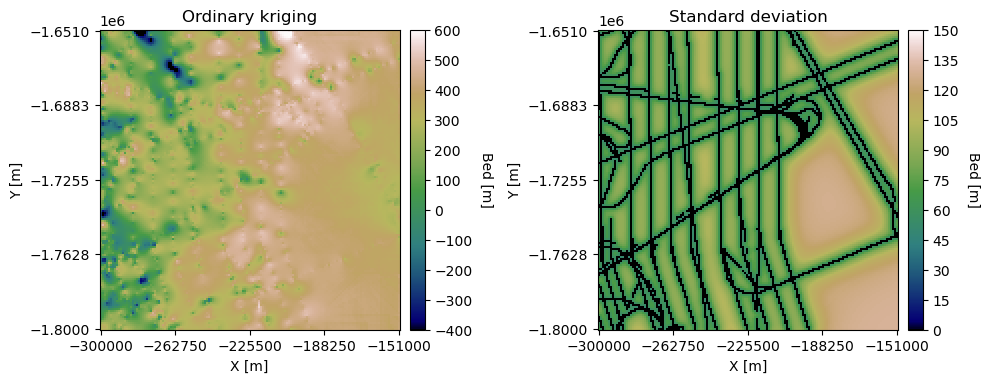

In [10]:
pred_trans_mat = pred_trans.reshape(grid_matrix.shape)
std_trans_mat = std_trans.reshape(grid_matrix.shape)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5))

im = ax1.pcolormesh(x_mat, y_mat, pred_trans_mat, vmin=-400, vmax=600, cmap='gist_earth')
ax1.set_xticks(np.linspace(xmin, xmax, 5))
ax1.set_yticks(np.linspace(ymin, ymax, 5))
ax1.set_title('Ordinary kriging')
ax1.set_xlabel('X [m]'); ax1.set_ylabel('Y [m]')

# make colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label('Bed [m]', rotation=270, labelpad=15)
ax1.axis('scaled')

im = ax2.pcolormesh(x_mat, y_mat, std_trans_mat, vmin=0, vmax=150, cmap='gist_earth')
ax2.set_xticks(np.linspace(xmin, xmax, 5))
ax2.set_yticks(np.linspace(ymin, ymax, 5))
ax2.set_title('Standard deviation')
ax2.set_xlabel('X [m]'); ax2.set_ylabel('Y [m]')

# make colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(0, 150, 11), cax=cax)
cbar.set_label('Bed [m]', rotation=270, labelpad=15)
ax2.axis('scaled')

plt.tight_layout()
plt.show()

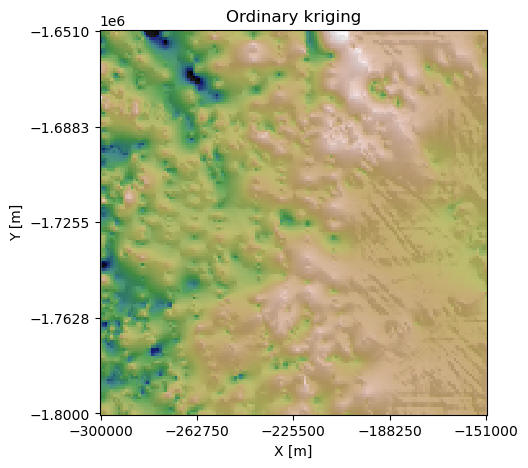

In [11]:
# make hillshade plot for visualizing
hillshade = es.hillshade(pred_trans_mat, azimuth = 210, altitude = 10)

plt.figure(figsize=(5,5))
plt.pcolormesh(x_mat, y_mat, pred_trans_mat, vmin=-400, vmax=600, cmap='gist_earth')
plt.pcolormesh(x_mat, y_mat, hillshade, cmap='Greys', alpha=0.1)
plt.title('Ordinary kriging')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.xticks(np.linspace(xmin, xmax, 5))
plt.yticks(np.linspace(ymin, ymax, 5))
plt.show()

Here, the righthand side of the ordinary kriging output is higher elevation than the simple kriging map. This is because ordinary kriging accounts for the large-scale trend of increasing elevation from left to right. However, there appear to be some artifacts in this region as well. This is because this area does not have many measurements, making it difficult to reliably estimate the local mean. This issue could be improved by increasing the search radius.

## Difference between simple kriging and ordinary kriging

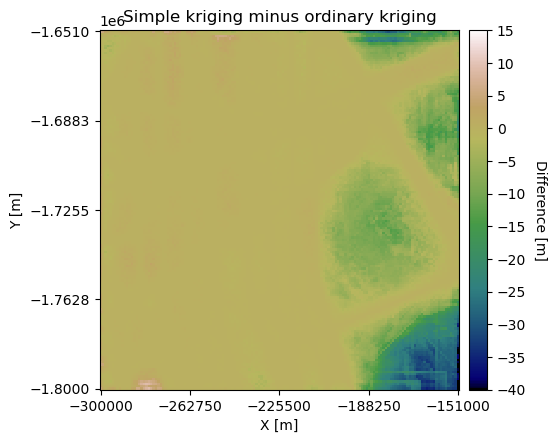

In [12]:
# plot difference
plt.figure(figsize=(5,5))
im = plt.pcolormesh(x_mat, y_mat, spred_trans_mat-pred_trans_mat, vmin=-40, vmax=15, cmap='gist_earth')
plt.title('Simple kriging minus ordinary kriging')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.xticks(np.linspace(xmin, xmax, 5))
plt.yticks(np.linspace(ymin, ymax, 5))

# make colorbar
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-40, 15, 12), cax=cax)
cbar.set_label('Difference [m]', rotation=270, labelpad=15)
ax.axis('scaled')
plt.show()

The differences tend to be the most pronounced in areas that are not near conditioning points.


## Kriging roughness

You'll also notice that parts of kriging outputs look quite smooth. This is because kriging performs interpolations by averaging measurements. Let's compare the variograms of the data and the kriging results to see how they differ.

Notice that we're using the simple kriging values prior to back transfo.rmation because the experimental variogram was computed on normalized data.

In [13]:
# compute simple kriging variogram
coords_s = Pred_grid_xy
values_s = est_SK

VS = skg.Variogram(coords_s, values_s, bin_func='even', n_lags=n_lags, 
                   maxlag=maxlag, normalize=False)

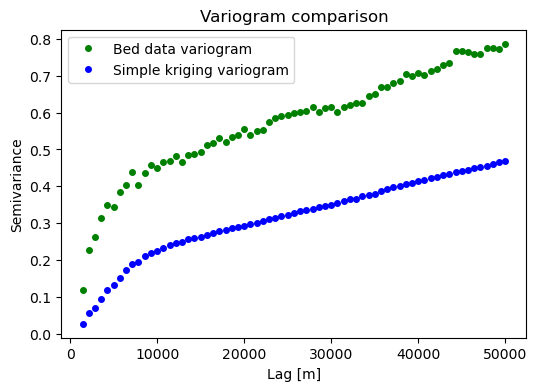

In [14]:
# experimental variogram (from beginning of script)
xe = V1.bins
ye = V1.experimental

# simple kriging variogram
xs = VS.bins
ys = VS.experimental

plt.figure(figsize=(6,4))
plt.plot(xe,ye,'og', markersize=4, label='Bed data variogram')
plt.plot(xs,ys,'ob', markersize=4, label='Simple kriging variogram')
plt.title('Variogram comparison')
plt.xlabel('Lag [m]'); plt.ylabel('Semivariance')  
plt.legend(loc='upper left')
plt.show()